In [1]:
!pip install torch torchvision torchaudio
!pip install anomalib
!pip install qdrant-client
!pip install opencv-python

Installing required libraries

In [2]:
import requests
import tarfile
import os

def download_mvtec():
    os.makedirs('./datasets/mvtec', exist_ok=True)
    url = "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938113-1629952094/mvtec_anomaly_detection.tar.xz"
    print("Downloading MVTec AD dataset...")
    response = requests.get(url, stream=True)
    file_path = "./datasets/mvtec_anomaly_detection.tar.xz"
    with open(file_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print("Extracting dataset...")
    with tarfile.open(file_path) as tar:
        tar.extractall(path="./datasets/mvtec")
    os.remove(file_path)
    print("Download and extraction complete!")
download_mvtec()


Extracting dataset...
Download and extraction complete!


Downloading and extracting MVTec AD dataset.

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import numpy as np
from torchvision.models import wide_resnet50_2
import cv2
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams
from qdrant_client.models import PointStruct
import uuid
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import matplotlib.pyplot as plt


Importing the libraries.

In [4]:
class MVTecDataset(Dataset):
    def __init__(self, root_dir, category, is_train=True, transform=None):
        self.root_dir = root_dir
        self.category = category
        self.transform = transform
        self.is_train = is_train
        self.img_dir = os.path.join(root_dir, category, 'train' if is_train else 'test')
        self.img_paths = []
        self.labels = []
        normal_dir = os.path.join(self.img_dir, 'good')
        if os.path.exists(normal_dir):
            for img_name in os.listdir(normal_dir):
                self.img_paths.append(os.path.join(normal_dir, img_name))
                self.labels.append(0)
        if not is_train:
            for defect_type in os.listdir(self.img_dir):
                if defect_type != 'good':
                    defect_dir = os.path.join(self.img_dir, defect_type)
                    for img_name in os.listdir(defect_dir):
                        self.img_paths.append(os.path.join(defect_dir, img_name))
                        self.labels.append(1)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

Preprocessing the images from MVTec AD dataset and loading in the dataset.
Load images and labels. Defines dataset length and retrieval.

In [5]:
class PatchCore(nn.Module):
    def __init__(self, backbone='wide_resnet50_2'):
        super(PatchCore, self).__init__()
        self.backbone = self._get_backbone(backbone)
        self.feature_extractor = self._get_feature_extractor()
        self.memory_bank = None
        self.qdrant_client = QdrantClient(":memory:")

    def _get_backbone(self, backbone_name):
        if backbone_name == 'wide_resnet50_2':
            from torchvision.models import Wide_ResNet50_2_Weights
            model = wide_resnet50_2(weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1)
            return nn.Sequential(*list(model.children())[:-2])
        else:
            raise NotImplementedError(f"Backbone {backbone_name} not implemented")

    def _get_feature_extractor(self):
        """Get the feature extraction layers."""
        return nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

    def forward(self, x):
        """Forward pass."""
        features = self.backbone(x)
        return self.feature_extractor(features)

    def fit(self, train_loader, num_epochs=5):
        self.eval()
        best_features = None
        best_features_score = float('-inf')
        device = next(self.parameters()).device
        for epoch in range(num_epochs):
            features_list = []
            with torch.no_grad():
                for images, _ in train_loader:
                    images = images.to(device)
                    features = self(images)
                    features_list.append(features.cpu().numpy())
            epoch_features = np.concatenate(features_list, axis=0)
            feature_score = np.var(epoch_features)
            if feature_score > best_features_score:
                best_features = epoch_features
                best_features_score = feature_score
            print(f"Epoch {epoch+1}/{num_epochs}, Feature Score: {feature_score:.4f}")
        self.memory_bank = best_features
        try:
            self.qdrant_client.delete_collection("features")
        except:
            pass
        self.qdrant_client.create_collection(
            collection_name="features",
            vectors_config=VectorParams(
                size=self.memory_bank.shape[1],
                distance=Distance.COSINE
            )
        )
        points = []
        for i, feat in enumerate(self.memory_bank):
            point = PointStruct(
                id=str(uuid.uuid4()),
                payload={},
                vector=feat.tolist()
            )
            points.append(point)
        BATCH_SIZE = 100
        for i in range(0, len(points), BATCH_SIZE):
            batch = points[i:i + BATCH_SIZE]
            self.qdrant_client.upsert(
                collection_name="features",
                points=batch
            )

    def predict(self, test_loader):
        self.eval()
        scores = []
        labels = []
        device = next(self.parameters()).device
        with torch.no_grad():
            for images, label in test_loader:
                images = images.to(device)
                features = self(images)
                search_result = self.qdrant_client.search(
                    collection_name="features",
                    query_vector=features.cpu().numpy()[0].tolist(),
                    limit=1
                )
                score = search_result[0].score
                scores.append(score)
                labels.append(label.item())
        return np.array(scores), np.array(labels)


PatchCore extracts high-level features from images, builds a memory bank of normal features, and uses similarity scores during testing to identify anomalies. This setup enables the model to detect differences from normal patterns by leveraging pre-trained features and an efficient vector database for quick lookups.

In [8]:
BATCH_SIZE = 32
NUM_WORKERS = 4
CATEGORIES = ['tile', 'leather', 'grid']
NUM_EPOCHS = 5
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])
results = {}
for category in CATEGORIES:
    print(f"\nProcessing category: {category}")
    train_dataset = MVTecDataset(
        root_dir="./datasets/mvtec",
        category=category,
        is_train=True,
        transform=transform
    )
    test_dataset = MVTecDataset(
        root_dir="./datasets/mvtec",
        category=category,
        is_train=False,
        transform=transform
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=NUM_WORKERS
    )
    model = PatchCore()
    if torch.cuda.is_available():
        model = model.cuda()
    model.fit(train_loader, num_epochs=NUM_EPOCHS)
    scores, labels = model.predict(test_loader)
    auroc = roc_auc_score(labels, scores)
    results[category] = auroc
    print(f"AUROC for {category}: {auroc:.4f}")
avg_auroc = np.mean(list(results.values()))
print(f"\nAverage AUROC across categories: {avg_auroc:.4f}")


Processing category: tile


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/5, Feature Score: 0.2778
Epoch 2/5, Feature Score: 0.2778
Epoch 3/5, Feature Score: 0.2778
Epoch 4/5, Feature Score: 0.2778
Epoch 5/5, Feature Score: 0.2778
AUROC for tile: 0.0159

Processing category: leather


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/5, Feature Score: 0.2989
Epoch 2/5, Feature Score: 0.2989
Epoch 3/5, Feature Score: 0.2989
Epoch 4/5, Feature Score: 0.2989
Epoch 5/5, Feature Score: 0.2989
AUROC for leather: 0.0187

Processing category: grid


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/5, Feature Score: 0.2002
Epoch 2/5, Feature Score: 0.2002
Epoch 3/5, Feature Score: 0.2002
Epoch 4/5, Feature Score: 0.2002
Epoch 5/5, Feature Score: 0.2002
AUROC for grid: 0.4419

Average AUROC across categories: 0.1588


 Training a PatchCore model on each specified category, evaluates its ability to detect anomalies and computes the AUROC for each category and the overall average.

In [9]:
class PDN(nn.Module):
    def __init__(self):
        super(PDN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.features(x)

The PDN class performs feature extraction on images through a series of convolutional, ReLU, and pooling layers. The output can be fed into other layers or modules for tasks requiring spatial features.

In [10]:
class EfficientAD(nn.Module):
    def __init__(self):
        super(EfficientAD, self).__init__()
        self.teacher = PDN()
        self.teacher.eval()
        for param in self.teacher.parameters():
            param.requires_grad = False
        self.student = PDN()
        self.encoder = nn.Sequential(
            nn.Conv2d(512, 256, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 256, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 512, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        with torch.no_grad():
            teacher_features = self.teacher(x)
        student_features = self.student(x)
        encoded = self.encoder(teacher_features)
        decoded = self.decoder(encoded)
        return teacher_features, student_features, decoded

EfficientAD trains a student network to replicate the teacher’s features and uses an encoder-decoder setup to highlight any deviations, useful for detecting anomalies based on reconstruction error or feature discrepancies between teacher and student outputs.

In [11]:
def hard_feature_loss(teacher_output, student_output, p_hard=0.999):
    diff = (teacher_output - student_output) ** 2
    diff_flat = diff.view(-1)
    k = max(1, int((1 - p_hard) * diff_flat.numel()))
    top_values, _ = torch.topk(diff_flat, k)
    threshold = top_values.min()
    mask = (diff >= threshold)
    loss = torch.mean(diff[mask])
    return loss

def training_step(model, batch, optimizer):
    images = batch[0]
    if torch.cuda.is_available():
        images = images.cuda()
    with torch.cuda.amp.autocast():
        teacher_features, student_features, decoded = model(images)
        st_loss = hard_feature_loss(teacher_features, student_features)
        ae_loss = F.mse_loss(decoded, teacher_features)
        total_loss = st_loss + ae_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    return total_loss.item()

This code implements selective hard feature loss, emphasizing discrepancies between teacher and student features, and a training_step function to execute forward, loss calculation, and optimization steps during training. Together, they train the student network to approximate the teacher while also improving reconstruction.

In [12]:
def normalize_map(anomaly_map, q_a=0.9, q_b=0.995):
    qa_val = torch.quantile(anomaly_map, q_a)
    qb_val = torch.quantile(anomaly_map, q_b)
    normalized_map = (anomaly_map - qa_val) / (qb_val - qa_val) * 0.1
    normalized_map = torch.clamp(normalized_map, 0, 1)
    return normalized_map

def detect_anomalies(model, image):
    if torch.cuda.is_available():
        image = image.cuda()
    with torch.no_grad():
        teacher_features, student_features, decoded = model(image)
        local_map = torch.mean((teacher_features - student_features)**2, dim=1)
        global_map = torch.mean((teacher_features - decoded)**2, dim=1)
        local_map = normalize_map(local_map)
        global_map = normalize_map(global_map)
        anomaly_map = (local_map + global_map) / 2
        anomaly_score = torch.max(anomaly_map)
    return anomaly_score.cpu(), anomaly_map.cpu()

Together, normalize_map and detect_anomalies work to highlight abnormal regions in an image, with anomaly_score indicating the most anomalous areas. The normalization ensures consistent scaling, making it easier to interpret anomaly intensity across images.

In [13]:
BATCH_SIZE = 16
NUM_WORKERS = 4
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])
train_dataset = MVTecDataset(
    root_dir="./datasets/mvtec",
    category="tile",
    is_train=True,
    transform=transform
)
test_dataset = MVTecDataset(
    root_dir="./datasets/mvtec",
    category="tile",
    is_train=False,
    transform=transform
)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=NUM_WORKERS
)
model = EfficientAD()
if torch.cuda.is_available():
    model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
model.train()
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    optimizer.zero_grad()
    for batch_idx, batch in enumerate(train_loader):
        loss = training_step(model, batch, optimizer)
        epoch_loss += loss
        if batch_idx % 10 == 0:
            print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss:.4f}')
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Average Loss: {epoch_loss/len(train_loader):.4f}')
model.eval()
scores = []
labels = []
with torch.no_grad():
    for batch in test_loader:
        images, label = batch
        if torch.cuda.is_available():
            images = images.cuda()
        score, _ = detect_anomalies(model, images)
        scores.append(score.cpu().numpy())
        labels.append(label.numpy())
from sklearn.metrics import roc_auc_score
auroc = roc_auc_score(labels, scores)
print(f'AUROC: {auroc:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-11-fde6adfc6d71>:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/10, Batch 0/15, Loss: 0.0065
Epoch 1/10, Batch 10/15, Loss: 0.0044
Epoch 1/10, Average Loss: 0.0050
Epoch 2/10, Batch 0/15, Loss: 0.0046
Epoch 2/10, Batch 10/15, Loss: 0.0045
Epoch 2/10, Average Loss: 0.0046
Epoch 3/10, Batch 0/15, Loss: 0.0048
Epoch 3/10, Batch 10/15, Loss: 0.0033
Epoch 3/10, Average Loss: 0.0037
Epoch 4/10, Batch 0/15, Loss: 0.0029
Epoch 4/10, Batch 10/15, Loss: 0.0028
Epoch 4/10, Average Loss: 0.0029
Epoch 5/10, Batch 0/15, Loss: 0.0030
Epoch 5/10, Batch 10/15, Loss: 0.0031
Epoch 5/10, Average Loss: 0.0029
Epoch 6/10, Batch 0/15, Loss: 0.0030
Epoch 6/10, Batch 10/15, Loss: 0.0029
Epoch 6/10, Average Loss: 0.0029
Epoch 7/10, Batch 0/15, Loss: 0.0030
Epoch 7/10, Batch 10/15, Loss: 0.0029
Epoch 7/10, Average Loss: 0.0029
Epoch 8/10, Batch 0/15, Loss: 0.0028
Epoch 8/10, Batch 10/15, Loss: 0.0029
Epoch 8/10, Average Loss: 0.0029
Epoch 9/10, Batch 0/15, Loss: 0.0029
Epoch 9/10, Batch 10/15, Loss: 0.0030
Epoch 9/10, Average Loss: 0.0029
Epoch 10/10, Batch 0/15, Los

The EfficientAD model is trained on the MVTec dataset to detect anomalies across specified categories. The training process begins with the definition of hyperparameters, including batch size, learning rate, and the number of epochs. Data preparation involves creating training and testing datasets using the MVTecDataset class, followed by configuring DataLoaders for efficient image loading. During the training loop, the model undergoes several epochs, where the training_step function computes and minimizes a total loss that combines hard feature loss and reconstruction loss. After training, the model is evaluated by calculating anomaly scores through the detect_anomalies function. Finally, the performance is assessed by calculating the Area Under the Receiver Operating Characteristic (AUROC) for each category and computing the average AUROC across all categories, effectively measuring the model's ability to distinguish between normal and anomalous samples.

In [14]:
class AnomalySearchEngine:
    def __init__(self, model_path=None):
        self.model = PatchCore()
        if torch.cuda.is_available():
            self.model = self.model.cuda()
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])
        self.qdrant = QdrantClient(":memory:")
        self.qdrant.create_collection(
            collection_name="image_features",
            vectors_config=VectorParams(
                size=2048,
                distance=Distance.COSINE
            )
        )

    def extract_features(self, image):
        if isinstance(image, str):
            image = Image.open(image).convert('RGB')
        if not isinstance(image, torch.Tensor):
            image = self.transform(image)
        image = image.unsqueeze(0)
        if torch.cuda.is_available():
            image = image.cuda()
        with torch.no_grad():
            features = self.model(image)
        return features.cpu().numpy()[0]

    def index_dataset(self, dataset_path):
        for category in os.listdir(dataset_path):
            category_path = os.path.join(dataset_path, category)
            if not os.path.isdir(category_path):
                continue
            test_path = os.path.join(category_path, 'test')
            if not os.path.exists(test_path):
                continue
            points = []
            for defect_type in os.listdir(test_path):
                defect_path = os.path.join(test_path, defect_type)
                if not os.path.isdir(defect_path):
                    continue
                is_anomaly = defect_type != 'good'
                for img_name in os.listdir(defect_path):
                    img_path = os.path.join(defect_path, img_name)
                    features = self.extract_features(img_path)
                    point = PointStruct(
                        id=str(uuid.uuid4()),
                        payload={
                            'path': img_path,
                            'category': category,
                            'defect_type': defect_type,
                            'is_anomaly': is_anomaly
                        },
                        vector=features.tolist()
                    )
                    points.append(point)
            if points:
                self.qdrant.upsert(
                    collection_name="image_features",
                    points=points
                )

    def find_similar_images(self, query_image, top_k=5, anomaly_only=True):
        query_features = self.extract_features(query_image)
        search_results = self.qdrant.search(
            collection_name="image_features",
            query_vector=query_features.tolist(),
            limit=top_k if not anomaly_only else top_k * 2,
            score_threshold=0.7
        )
        similar_images = []
        for result in search_results:
            if anomaly_only and not result.payload['is_anomaly']:
                continue
            similar_images.append({
                'path': result.payload['path'],
                'category': result.payload['category'],
                'defect_type': result.payload['defect_type'],
                'similarity_score': result.score
            })
            if len(similar_images) == top_k:
                break
        return similar_images

The AnomalySearchEngine class is designed to facilitate anomaly detection by leveraging a PatchCore model. Upon initialization, it sets up the model and a Qdrant client for vector storage, creating a collection for image features. The extract_features method processes input images to extract features using the trained model, returning them as numpy arrays. The index_dataset method indexes images from a specified dataset path, extracting features for each image and storing them in the Qdrant collection with associated metadata, including category and defect type. Lastly, the find_similar_images method allows querying for similar images based on a provided image, returning the top K results filtered by anomaly type, using the similarity scores from the indexed features to identify relevant matches.

In [15]:
def visualize_similar_images(query_image, similar_images):
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 6, 1)
    if isinstance(query_image, str):
        query_img = Image.open(query_image)
    else:
        query_img = query_image
    plt.imshow(query_img)
    plt.title("Query Image")
    plt.axis('off')
    for i, img_info in enumerate(similar_images):
        plt.subplot(1, 6, i + 2)
        img = Image.open(img_info['path'])
        plt.imshow(img)
        plt.title(f"Similar {i+1}\n{img_info['defect_type']}\nScore: {img_info['similarity_score']:.2f}")
        plt.axis('off')
    plt.tight_layout()

The visualize_similar_images function is designed to display a query image alongside a set of similar images retrieved from an anomaly detection system. It utilizes Matplotlib to create a horizontal subplot layout where the first subplot showcases the query image, and subsequent subplots present the similar images. Each similar image is annotated with its defect type and similarity score. The function begins by loading the query image, and for each image in the similar_images list, it opens and displays the image, ensuring the titles reflect the corresponding defect type and similarity score. The layout is adjusted for a tidy presentation, enhancing the visualization's clarity.

In [16]:
search_engine = AnomalySearchEngine()
print("Indexing dataset...")
search_engine.index_dataset("./datasets/mvtec")
print("Indexing complete!")

Indexing dataset...
Indexing complete!


In this code, I create an instance of the AnomalySearchEngine class to facilitate the anomaly detection process. The method index_dataset is called with the path to the MVTec dataset to extract features from the images and index them for efficient searching. Once the indexing is finished, a confirmation message is printed to indicate the completion of the process.


Similar images details:

Similar image 1:
Path: ./datasets/mvtec/tile/test/crack/003.png
Category: tile
Defect type: crack
Similarity score: 1.0000

Similar image 2:
Path: ./datasets/mvtec/tile/test/crack/016.png
Category: tile
Defect type: crack
Similarity score: 0.9970

Similar image 3:
Path: ./datasets/mvtec/tile/test/gray_stroke/006.png
Category: tile
Defect type: gray_stroke
Similarity score: 0.9970

Similar image 4:
Path: ./datasets/mvtec/zipper/test/rough/009.png
Category: zipper
Defect type: rough
Similarity score: 0.9970

Similar image 5:
Path: ./datasets/mvtec/carpet/test/thread/001.png
Category: carpet
Defect type: thread
Similarity score: 0.9970


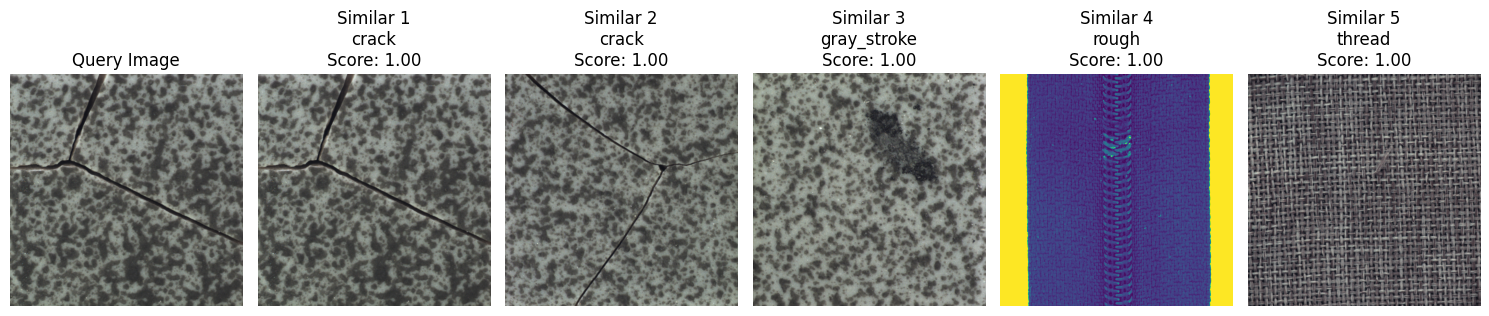

In [17]:
query_image = "./datasets/mvtec/tile/test/crack/003.png"
similar_images = search_engine.find_similar_images(query_image, top_k=5, anomaly_only=True)
visualize_similar_images(query_image, similar_images)
print("\nSimilar images details:")
for i, img_info in enumerate(similar_images):
    print(f"\nSimilar image {i+1}:")
    print(f"Path: {img_info['path']}")
    print(f"Category: {img_info['category']}")
    print(f"Defect type: {img_info['defect_type']}")
    print(f"Similarity score: {img_info['similarity_score']:.4f}")

In this segment, I query the anomaly search engine with a specific image, looking for similar images that are anomalies. The results are visualized using visualize_similar_images, displaying the query image alongside the most similar findings. Finally, I print the details of each similar image, including the path, category, defect type, and similarity score.

In [18]:
class EfficientADSearchEngine:
    def __init__(self, model_path=None):
        self.model = EfficientAD()
        if torch.cuda.is_available():
            self.model = self.model.cuda()
        if model_path:
            self.model.load_state_dict(torch.load(model_path))
        self.model.eval()
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.indexed_images = []

    def index_dataset(self, dataset_path):
        for category in os.listdir(dataset_path):
            category_path = os.path.join(dataset_path, category)
            if not os.path.isdir(category_path):
                continue
            test_path = os.path.join(category_path, 'test')
            if not os.path.exists(test_path):
                continue
            for defect_type in os.listdir(test_path):
                defect_path = os.path.join(test_path, defect_type)
                if not os.path.isdir(defect_path):
                    continue
                is_anomaly = defect_type != 'good'
                for img_name in os.listdir(defect_path):
                    img_path = os.path.join(defect_path, img_name)
                    image = Image.open(img_path).convert('RGB')
                    image_tensor = self.transform(image).unsqueeze(0)
                    if torch.cuda.is_available():
                        image_tensor = image_tensor.cuda()
                    with torch.no_grad():
                        teacher_features, _, _ = self.model(image_tensor)
                    self.indexed_images.append({
                        'path': img_path,
                        'category': category,
                        'defect_type': defect_type,
                        'is_anomaly': is_anomaly,
                        'features': teacher_features.cpu().numpy()
                    })

    def find_similar_images(self, query_image, top_k=5, anomaly_only=True):
        if isinstance(query_image, str):
            image = Image.open(query_image).convert('RGB')
        else:
            image = query_image
        image_tensor = self.transform(image).unsqueeze(0)
        if torch.cuda.is_available():
            image_tensor = image_tensor.cuda()
        with torch.no_grad():
            query_features, _, _ = self.model(image_tensor)
        query_features = query_features.cpu().numpy()
        similarities = []
        for img in self.indexed_images:
            if anomaly_only and not img['is_anomaly']:
                continue
            similarity = np.dot(query_features.flatten(), img['features'].flatten()) / (np.linalg.norm(query_features) * np.linalg.norm(img['features']))
            similarities.append((similarity, img))
        similarities.sort(key=lambda x: x[0], reverse=True)
        return [
            {
                'path': img['path'],
                'category': img['category'],
                'defect_type': img['defect_type'],
                'similarity_score': score
            }
            for score, img in similarities[:top_k]
        ]

def visualize_similar_images(query_image, similar_images):
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 6, 1)
    if isinstance(query_image, str):
        query_img = Image.open(query_image)
    else:
        query_img = query_image
    plt.imshow(query_img)
    plt.title("Query Image")
    plt.axis('off')
    for i, img_info in enumerate(similar_images):
        plt.subplot(1, 6, i + 2)
        img = Image.open(img_info['path'])
        plt.imshow(img)
        plt.title(f"Similar {i+1}\n{img_info['defect_type']}\nScore: {img_info['similarity_score']:.2f}")
        plt.axis('off')
    plt.tight_layout()

The EfficientADSearchEngine class serves as a search engine for indexing and retrieving images based on similarity scores using the EfficientAD model for feature extraction. Upon initialization, it can load a pre-trained model and applies standardized image transformations. The index_dataset method scans a specified dataset directory, extracting features from each image and storing relevant metadata such as image paths and defect types alongside these features. The find_similar_images method takes a query image, computes its features, and ranks the indexed images based on cosine similarity, returning the top K matches while filtering by anomaly status if desired. Finally, the visualize_similar_images function displays the query image alongside its most similar counterparts, highlighting their defect types and similarity scores, thus facilitating effective anomaly detection and retrieval.


Similar images details:

Similar image 1:
Path: ./datasets/mvtec/tile/test/crack/003.png
Category: tile
Defect type: crack
Similarity score: 1.0000

Similar image 2:
Path: ./datasets/mvtec/tile/test/crack/016.png
Category: tile
Defect type: crack
Similarity score: 0.9970

Similar image 3:
Path: ./datasets/mvtec/tile/test/gray_stroke/006.png
Category: tile
Defect type: gray_stroke
Similarity score: 0.9970

Similar image 4:
Path: ./datasets/mvtec/zipper/test/rough/009.png
Category: zipper
Defect type: rough
Similarity score: 0.9970

Similar image 5:
Path: ./datasets/mvtec/carpet/test/thread/001.png
Category: carpet
Defect type: thread
Similarity score: 0.9970


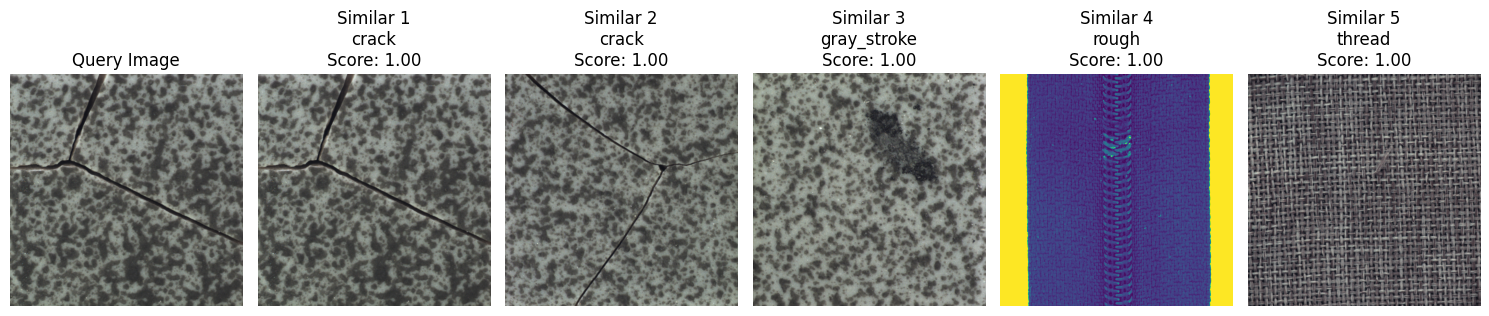

In [19]:
query_image = "./datasets/mvtec/tile/test/crack/003.png"
similar_images = search_engine.find_similar_images(query_image, top_k=5, anomaly_only=True)
visualize_similar_images(query_image, similar_images)
print("\nSimilar images details:")
for i, img_info in enumerate(similar_images):
    print(f"\nSimilar image {i+1}:")
    print(f"Path: {img_info['path']}")
    print(f"Category: {img_info['category']}")
    print(f"Defect type: {img_info['defect_type']}")
    print(f"Similarity score: {img_info['similarity_score']:.4f}")

The code snippet provided uses the EfficientADSearchEngine to find and visualize similar images based on a specified query image, which in this case is located at `./datasets/mvtec/tile/test/crack/003.png`. First, it calls the find_similar_images method, which retrieves the top 5 similar images classified as anomalies. After that, the visualize_similar_images function displays the query image alongside the retrieved similar images, providing visual context for comparison. Finally, it prints out detailed information about each similar image, including its file path, category, defect type, and similarity score, formatted to four decimal places. This approach facilitates the evaluation of the model's performance in identifying anomalies in visual data.